In [1967]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

cleaned_data = pd.read_csv("data/cleaned_data.csv", sep=',') 

### Data Augmentation (Feature creation)

As the aim of the project is to develop a machine learning model to predict real estate prices, research in this field was conducted.
There are two main categories of factors that can affect the value of a property: property characteristics and locational attributes (or neighborhood characteristics).

* **Property characteristics** are the structural attributes of the property, such as size, year of construction, amenities, type of property, among others.

The dataset __[*cleaned_data*](https://github.com/MaximSchuermans/immo-eliza/blob/main/data/cleaned_data.csv)__ is the result of the scraping process from __[Immoweb](https://www.immoweb.be/)__ and contains mainly property characteristics for 24,342 observations.

* **Neighborhood characteristics** include social demographics, proximity to, and quality of public services, such as schools, hospitals, and public transportation. Proximity to amenities such as grocery stores, restaurants, or commercial centers, as well as factors related to safety and environmental issues, such as crime rates or air quality, also play a role.

Regarding neighborhood characteristics, the dataset cleaned_data only includes the postal code.


#### Add featues: 

1. Region, province, and municipality: To add geo-spatial related data, the dataset is being merged with the __[*postal_codes_belgium*](https://data.gov.be/en/datasets/httpswwwodwbbeexploredatasetpostal-codes-belgium)__ dataframe, another dataset from the Geographical repository maintained by Opendatasoft. This repository contains a list of Belgian postal codes along with the corresponding region, province, and municipality.

2. Prosperity Index: The Prosperity Index is a comparative measure of the average income in a municipality relative to the national average. This value will be added from the __[fisc2022_c_NL](https://statbel.fgov.be/en/themes/households/taxable-income#figures)__ dataset, which contains fiscal statistics from 2022.

3. Total population and 'Population / km²': The __[Pop_density_en](https://statbel.fgov.be/en/themes/population/structure-population/population-density#figures)__ dataset includes total population and population density (Population / km²) by municipality, with data from January 2024.

4. Crime rate: The crime rate will be calculated using data from the Federal Police data portal __[criminal_figures_statistics_table](https://www.politie.be/statistieken/nl/criminaliteit/criminele-figuren/tabel?view=undefined&year=2023)__. The specific database contains criminal figures per year, per municipality. Only data from the year 2023 will be used, up to and including 31 December 2023. The total population mentioned above will be used to calculate the crime rate per 1,000 inhabitants.

No additional neighborhood characteristics will be added due to time constraints and difficulty in finding reliable data.

In [1968]:
# Load data used for adding features
postal_codes_belgium = pd.read_csv("data/postal-codes-belgium.csv", sep=';') 
codes_nis = pd.read_csv("data/codes-ins-nis-postaux-belgique.csv", sep=';') 
fiscal_statistics = pd.read_excel("data/fisc2022_C_NL.xls", sheet_name='Totaal', skiprows=5, header=[1])
pop_density = pd.read_excel("data/Pop_density_en.xlsx", sheet_name='2024', skiprows=0, header=[1])
criminal_figures = pd.read_csv("data/criminal_figures_statistics_table.csv", delimiter=";", skiprows=0, header=[1])

In [1969]:
# Create new dataframes with only the specified columns from each dataframes
postal_codes = pd.DataFrame({
    'geo_point': postal_codes_belgium['﻿Geo Point'],

    'postal_code': postal_codes_belgium['Postal Code'],

    'region': postal_codes_belgium['Région name (French)'],

    'province': postal_codes_belgium['Province name (French)'].combine_first(
                    postal_codes_belgium['Province name (Dutch)']).combine_first(
                    postal_codes_belgium['Région name (French)']),

    'municipality': postal_codes_belgium['Municipality name (French)'].combine_first(
                        postal_codes_belgium['Municipality name (Dutch)'])
})

nis = pd.DataFrame({
    'nis': codes_nis['NIS-code Municipaity'],

    'postal_code': codes_nis['Postal code'],
})

prosperity_index = pd.DataFrame({
    'nis': fiscal_statistics['Unnamed: 1'],

    'prosperity_index': fiscal_statistics['Unnamed: 18'],
})

population = pd.DataFrame({
    'nis': pop_density['Refnis'],

    'total_population': pop_density['Population'],

    'Population_km': pop_density['Population / km²'],
})

criminal_statistics = pd.DataFrame({
    'municipality': criminal_figures[' '],

    'crimes': criminal_figures['2023'],
})

In [1970]:
postal_codes.drop_duplicates(subset=['postal_code'], inplace=True)

* Prepare cleaned_data dataframe to merge

In [1971]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24396 entries, 0 to 24395
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Price                      24396 non-null  int64  
 1   Locality                   24396 non-null  object 
 2   Type_of_Property           24396 non-null  object 
 3   Subtype_of_Property        24396 non-null  object 
 4   State_of_the_Building      20601 non-null  object 
 5   Number_of_Rooms            24396 non-null  int64  
 6   Living_Area                23507 non-null  float64
 7   Fully_Equipped_Kitchen     24396 non-null  int64  
 8   Furnished                  11097 non-null  float64
 9   Open_fire                  1030 non-null   float64
 10  Terrace                    16502 non-null  float64
 11  Terrace_Area               10180 non-null  float64
 12  Garden                     5582 non-null   float64
 13  Garden_Area                5582 non-null   flo

In [1972]:
cleaned_data = cleaned_data.rename(columns={"Locality" : "postal_code"})

# Convert Postal_Code columns form both df to int
cleaned_data["postal_code"] = pd.to_numeric(cleaned_data["postal_code"], errors='coerce').astype('Int64')
postal_codes["postal_code"] = pd.to_numeric(postal_codes["postal_code"], errors='coerce').astype('Int64')

* Merge new features with clean_data 

In [1973]:
postal_codes = postal_codes.merge(nis, on=["postal_code"], how='inner', copy=True)

postal_codes = postal_codes.merge(prosperity_index, on=['nis'], how='inner', copy=True)

postal_codes = postal_codes.merge(population, on=['nis'], how='inner', copy=True)

postal_codes = postal_codes.merge(criminal_statistics, on=['municipality'], how='inner', copy=True)

real_estate_data = cleaned_data.merge(postal_codes, on=["postal_code"], how='inner', copy=True)

* Calculate crime rate per 1,000 inhabitants 

In [1974]:
real_estate_data['crimes'] = pd.to_numeric(real_estate_data['crimes'], errors='coerce')
real_estate_data['total_population'] = pd.to_numeric(real_estate_data['total_population'], errors='coerce')

real_estate_data['crime_rate'] = (real_estate_data['crimes'] / real_estate_data['total_population']) * 1000

* Convert Geo Point into 'latitude' and 'longitude' 

In [1975]:
# Convert Geo Point data to float
Geo_Point = real_estate_data['geo_point']
Geo_Point = [Geo_Point[i].split(',') for i in range(0,len(Geo_Point))]

Geo_Point_latitude= [float(Geo_Point[i][0:2][0]) for i in range(0,len(Geo_Point))]
Geo_Point_longitude= [float(Geo_Point[i][0:2][1]) for i in range(0,len(Geo_Point))]

# Add latitude and longitude coordinates
real_estate_data.insert(0,'longitude',Geo_Point_latitude)
real_estate_data.insert(1,'latitude', Geo_Point_longitude)

# Delte Geo Point column
del real_estate_data['geo_point']

* Reorder columns

In [1976]:
# Define column order
column_order = [
    "Price", "postal_code", "longitude", "latitude", "region", "province", 
    "municipality", "crime_rate", "total_population", "Population_km", 
    "prosperity_index"
] + [col for col in real_estate_data.columns if col not in [
    "Price", "postal_code", "longitude", "latitude", "region", "province", 
    "municipality", "crime_rate", "total_population", "Population_km", 
    "prosperity_index"
]]

# Reorder the DataFrame columns
real_estate_data = real_estate_data[column_order]

* Convert all column names and all string to lowercase 

In [1977]:
real_estate_data.columns = real_estate_data.columns.str.lower()
real_estate_data = real_estate_data.map(lambda x: x.lower() if isinstance(x, str) else x)

* Drop Unnecessary Columns and Duplicates

The columns 'nis', 'crimes', and 'total_population' were used to derive new features but are not needed for further analysis, as they contain redundant information already represented in other features.

In [1978]:
columns_to_drop = ['nis','total_population']
real_estate_data = real_estate_data.drop(columns=columns_to_drop)

real_estate_data.drop_duplicates(inplace=True)

In [1979]:
real_estate_data.head(10)

,price,postal_code,longitude,latitude,region,province,municipality,crime_rate,population_km,prosperity_index,...,terrace_area,garden,garden_area,surface_of_the_land,surface_area_plot_of_land,number_of_facades,swimming_pool,disabled_access,lift,crimes
0,475000,1800,50.930129,4.428578,région flamande,brabant flamand (le),vilvoorde,22.742122,2199.232426,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1079.0
1,895000,2000,51.248448,4.376134,région flamande,antwerpen,antwerpen,38.339890,2666.254939,87.0,...,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20886.0
2,289000,8680,51.090212,2.972217,région flamande,flandre occidentale (la),koekelare,9.176391,223.812277,98.0,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,81.0
3,775000,2980,51.263556,4.682858,région flamande,antwerpen,zoersel,13.609966,583.095609,121.0,...,NaN,NaN,NaN,NaN,3715.0,4.0,0.0,NaN,0.0,307.0
4,1495000,8670,51.121347,2.700627,région flamande,flandre occidentale (la),koksijde,21.628144,427.834883,137.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,466.0
5,259000,5030,50.562261,4.697015,région wallonne,namur,gembloux,17.285628,274.633658,110.0,...,NaN,1.0,200.0,200.0,200.0,NaN,NaN,NaN,NaN,458.0
6,230000,8690,51.014761,2.721211,région flamande,flandre occidentale (la),alveringem,11.148716,62.236370,96.0,...,NaN,1.0,1656.0,1656.0,1656.0,3.0,NaN,0.0,0.0,56.0
7,1195000,8300,51.346652,3.331958,région flamande,flandre occidentale (la),knokke-heist,24.697054,527.878757,150.0,...,NaN,NaN,NaN,NaN,NaN,2.0,0.0,0.0,1.0,803.0
8,429210,9052,51.003447,3.708325,région flamande,flandre orientale (la),gent,45.408517,1708.806368,103.0,...,12.0,NaN,NaN,NaN,NaN,3.0,0.0,0.0,1.0,12242.0
9,314000,1770,50.866522,4.093036,région flamande,brabant flamand (le),liedekerke,23.406837,1377.249099,103.0,...,10.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,1.0,328.0


***

### Data Cleaning 

#### Missing values

In [1980]:
# Column summary
summary = []
for col in real_estate_data.columns:
    missing_count = real_estate_data[col].isnull().sum()  
    missing_percentage = np.round(real_estate_data[col].isnull().mean() * 100, 3)
    unique = real_estate_data[col].nunique()
    summary.append([missing_count, f'{missing_percentage}%', unique])

# Create a DataFrame with summary
summary_df = pd.DataFrame(summary, index=real_estate_data.columns, columns=['Missing Count', 'Missing Percentage', 'Unique Values'])
print(summary_df)

                           Missing Count Missing Percentage  Unique Values
price                                  0               0.0%           1889
postal_code                            0               0.0%            874
longitude                              0               0.0%            856
latitude                               0               0.0%            856
region                                 0               0.0%              3
province                               0               0.0%             11
municipality                           0               0.0%            509
crime_rate                             0               0.0%            510
population_km                          0               0.0%            511
prosperity_index                       0               0.0%             72
type_of_property                       0               0.0%              2
subtype_of_property                    0               0.0%             23
state_of_the_building    

* Visualizing missing data

<Axes: >

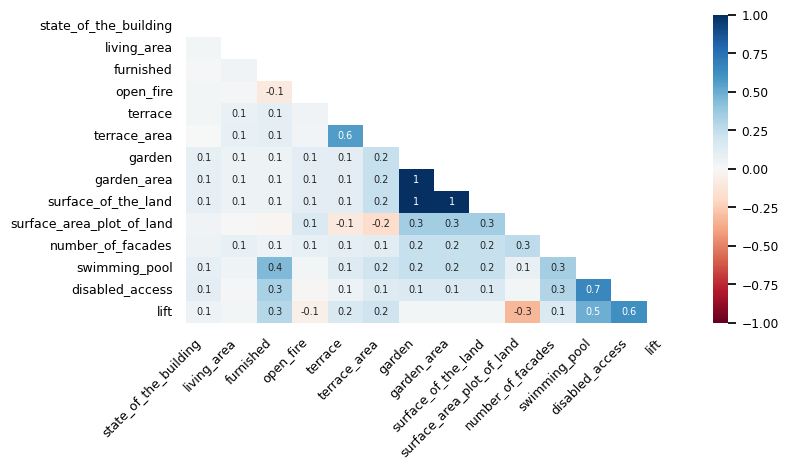

In [1981]:
msno.heatmap(real_estate_data, figsize=(8, 4), fontsize=9)

<Axes: >

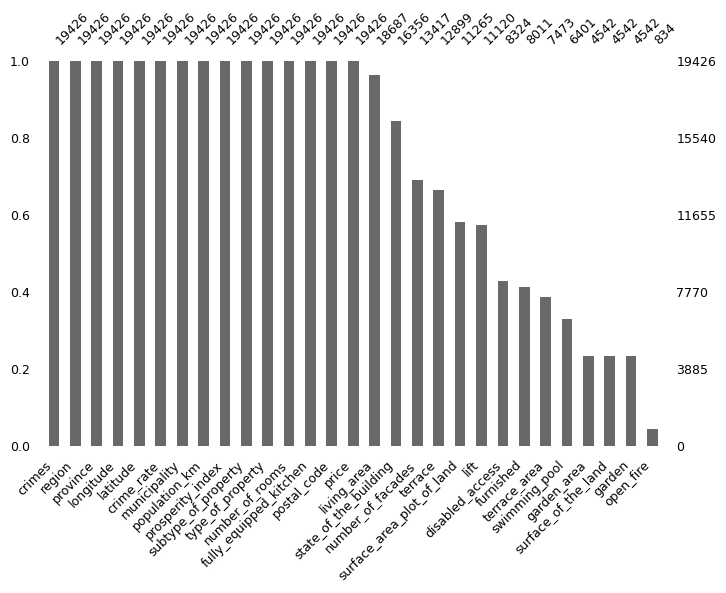

In [1982]:
# Visualize the count of non-null values for each column
msno.bar(real_estate_data, figsize=(8, 5), fontsize=9, sort="descending")

<Axes: >

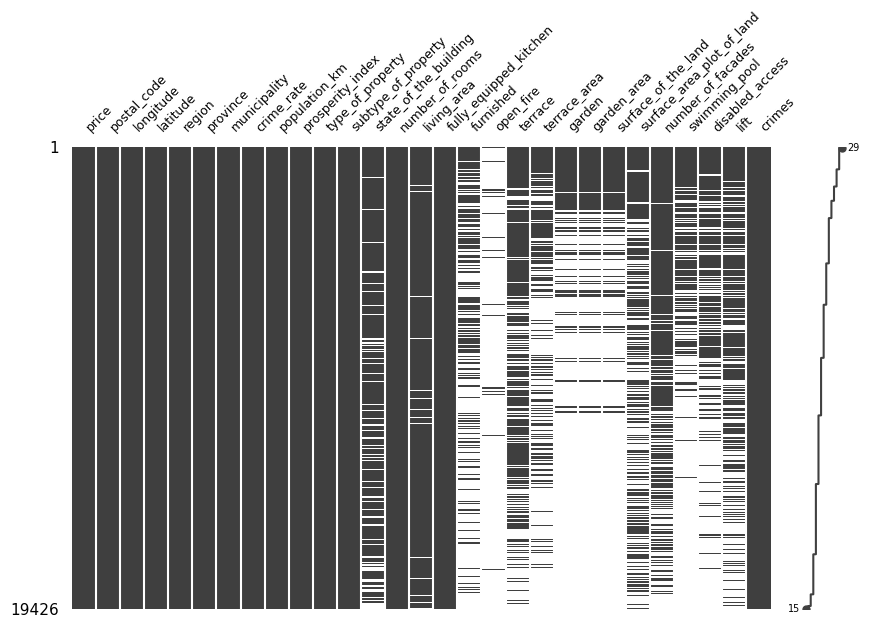

In [1983]:
sorted_data = msno.nullity_sort(real_estate_data, sort='descending') # or sort='ascending'
msno.matrix(sorted_data, figsize=(10, 6), fontsize=9)

* Missing values | Categorical variables

The feature 'open_fire' indicates the total number of chimneys each observation has. Since the exact count is not needed, this column will be transformed into a boolean column, representing whether an observation has a chimney or not.

In [1984]:
# Fill missing values wirh zero and replace all non-zero with 1
real_estate_data['open_fire'] = real_estate_data['open_fire'].fillna(0)
real_estate_data['open_fire'] = real_estate_data['open_fire'].apply(lambda x: 1 if x != 0 else 0)

The dataframe contains 8 boolean columns, where 1 represents True and 0 represents False, indicating whether an observation has specific features.
For these columns, all missing values will be assumed to represent False, meaning the observation does not have that feature.

The 8 boolean columns are:
* fully_equipped_kitchen
* furnished
* open_fire
* terrace
* garden
* swimming_pool
* disabled_access
* lift

In [1985]:
# Fill missing values in boolean columns with 0 = False
boolean_columns = ['furnished',
                'open_fire',
                'terrace',
                'garden',
                'swimming_pool',
                'disabled_access', 
                'lift']

real_estate_data[boolean_columns] = real_estate_data[boolean_columns].fillna(0)

The 'state of the building' column contains categorical variables. The missing values in this column are MCAR: Missing Completely At Random and account for 15.756% of the total observations. Mode imputation will be applied, as it is the most appropriate method for categorical variables. Before imputation, the data will be grouped by 'type_of_property' and 'municipality.' Observations that do not have a matching group will be imputed using the global mode.

In [1986]:
# Calculate the mode for each group (type_of_property, municipality)
mode_values = real_estate_data.groupby(['type_of_property', 'municipality'])['state_of_the_building'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

# Impute missing values 'state_of_the_building' with the mode of the corresponding group
def impute_with_group_mode(row):
    if pd.isna(row['state_of_the_building']):
        group_mode = mode_values.get((row['type_of_property'], row['municipality']))
        return group_mode
    return row['state_of_the_building']

# Apply the function to the 'state_of_the_building' column
real_estate_data['state_of_the_building'] = real_estate_data.apply(impute_with_group_mode, axis=1)

# Fill the remaining missing values with the global mode
real_estate_data['state_of_the_building'] = real_estate_data['state_of_the_building'].fillna(real_estate_data['state_of_the_building'].mode()[0])

* Missing values | Numerical variables

In [1987]:
# 'surface_of_the_land' | Check if two columns are the same
are_columns_equal = real_estate_data['surface_of_the_land'].equals(real_estate_data['garden_area'])
if are_columns_equal:
    print("The 'surface_of_the_land' and 'garden_area' columns contain identical data.")
else:
    print("The 'surface_of_the_land' and 'garden_area' columns have different values.")

The 'surface_of_the_land' and 'garden_area' columns contain identical data.


The column 'surface_of_the_land' will be dropped as it contains the same data as the column 'garden_area'.

In [1988]:
# delete Surface_of_the_Land column
del real_estate_data['surface_of_the_land']

In [1989]:
# Missing values for houses with a garden
missing_houses_with_garden = real_estate_data[(real_estate_data['type_of_property'] == 0) & 
                                            (real_estate_data['garden'] == 1) & 
                                            (real_estate_data['garden_area'].isna())].shape[0]

# Missing values for apartments with a garden
missing_apartments_with_garden = real_estate_data[(real_estate_data['type_of_property'] == 1) & 
                                                (real_estate_data['garden'] == 1) & 
                                                (real_estate_data['garden_area'].isna())].shape[0]

print(f"Missing values in garden area for houses with gardens: {missing_houses_with_garden}")
print(f"Missing values in garden area for apartments with gardens: {missing_apartments_with_garden}")

Missing values in garden area for houses with gardens: 0
Missing values in garden area for apartments with gardens: 0


All missing values in 'terrace_area' and 'garden_area' belong to observations that don't have a terrace or garden. Since the feature doesn't exist, the missing values are being filled with area = 0

In [1990]:
real_estate_data['garden_area'] = real_estate_data['garden_area'].fillna(0)
real_estate_data['terrace_area'] = real_estate_data['terrace_area'].fillna(0)

The columns 'garden_area' and 'terrace_area' represent both exterior spaces. 

In [1991]:
# Create new column 'ext_area' as the sum of 'garden_area' and 'terrace_area'
real_estate_data['ext_area'] = real_estate_data['garden_area'] + real_estate_data['terrace_area']

# Drop the 'garden_area' and 'terrace_area' columns
real_estate_data.drop(['garden_area', 'terrace_area'], axis=1, inplace=True)

In [1992]:
# Create a new column 'exterior_space' by combining 'garden' and 'terrace'
real_estate_data['garden'] = real_estate_data['garden'].astype(int)
real_estate_data['terrace'] = real_estate_data['terrace'].astype(int)

real_estate_data['exterior_space'] = (real_estate_data['garden'] | real_estate_data['terrace']).astype(int)

# Drop the 'garden' and 'terrace' columns
real_estate_data.drop(['garden', 'terrace'], axis=1, inplace=True)

The column 'living_area' contains a continuous variable and has only 3.639% of missing values.

Median imputation will be used, as it is the most appropriate method when the distribution of the data is skewed. Before imputing, the data will be grouped by 'type_of_property' and 'municipality.' Observations with no matching group will be imputed with the global median.

In [1993]:
# Group by 'type_of_property' and 'municipality' and calculate the median of 'living_area'
median_values = real_estate_data.groupby(['type_of_property', 'municipality'])['living_area'].median()

# Impute missing values 'living_area' with the median of the corresponding group
def impute_with_group_median(row):
    if pd.isna(row['living_area']):
        return median_values.loc[(row['type_of_property'], row['municipality'])]
    return row['living_area']

# Apply the function to the 'living_area' column
real_estate_data['living_area'] = real_estate_data.apply(impute_with_group_median, axis=1)

# Fill the remaining missing values with the global median
real_estate_data['living_area'] = real_estate_data['living_area'].fillna(real_estate_data['living_area'].median())

In [1994]:
real_estate_data['living_area'].describe()

count    19426.000000
mean       166.885283
std        132.620382
min         12.000000
25%         93.000000
50%        138.000000
75%        198.000000
max       4829.000000
Name: living_area, dtype: float64

The 'number_of_facades' column contains discrete numerical variables. The missing values in this column are MCAR: Missing Completely At Random, and account for  29.915% of the total observations. 

Mode imputation will be used, as it is the most appropriate method when data is discrete. Before imputing, the data will be grouped by 'type_of_property' and 'municipality.' Observations with no matching group will be imputed with the global median.

In [1995]:
# Group by 'type_of_property' and 'municipality' and calculate the mode of 'number_of_facades' for each group
median_values_facades = real_estate_data.groupby(['type_of_property', 'municipality'])['number_of_facades'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

# Impute missing values 'number_of_facades' with the median of corresponding group
def impute_with_group_mode(row):
    if pd.isna(row['number_of_facades']):
        return median_values_facades.loc[(row['type_of_property'], row['municipality'])]
    return row['number_of_facades']

# Apply the function to the 'number_of_facades' column
real_estate_data['number_of_facades'] = real_estate_data.apply(impute_with_group_mode, axis=1)

# Fill the remaining missing values with global median
real_estate_data['number_of_facades'] = real_estate_data['number_of_facades'].fillna(real_estate_data['number_of_facades'].mode()[0])

Zero is not a valid value for the feature 'surface_area_plot_of_land'. All zeros are being converted to NaN in order to facilitate imputation in the next steps.

In [1996]:
# Fill 'Surface_area_plot_of_land' zeros with np.nan 
real_estate_data['surface_area_plot_of_land'] = real_estate_data['surface_area_plot_of_land'].replace(0, np.nan)

In [1997]:
# Count the number of apartments and houses with non-missing 'surface_area_plot_of_land'
apartment_with_surface = real_estate_data[(real_estate_data['type_of_property'] == 'apartment') & (real_estate_data['surface_area_plot_of_land'].notna())].shape[0]
house_with_surface = real_estate_data[(real_estate_data['type_of_property'] == 'house') & (real_estate_data['surface_area_plot_of_land'].notna())].shape[0]

print(f"Number of apartments with surface area: {apartment_with_surface}")
print(f"Number of houses with surface area: {house_with_surface}")

# Calculate the percentage of missing surface area for apartments and houses
apartment_missing_surface = real_estate_data[(real_estate_data['type_of_property'] == 'apartment') & (real_estate_data['surface_area_plot_of_land'].isna())].shape[0]
house_missing_surface = real_estate_data[(real_estate_data['type_of_property'] == 'house') & (real_estate_data['surface_area_plot_of_land'].isna())].shape[0]

total_apartments = real_estate_data[real_estate_data['type_of_property'] == 'apartment'].shape[0]
total_houses = real_estate_data[real_estate_data['type_of_property'] == 'house'].shape[0]

apartment_missing_percentage = (apartment_missing_surface / total_apartments) * 100 if total_apartments > 0 else 0
house_missing_percentage = (house_missing_surface / total_houses) * 100 if total_houses > 0 else 0

print(f"Percentage of apartments without surface area: {apartment_missing_percentage:.2f}%")
print(f"Percentage of houses without surface area: {house_missing_percentage:.2f}%")

Number of apartments with surface area: 0
Number of houses with surface area: 10632
Percentage of apartments without surface area: 100.00%
Percentage of houses without surface area: 5.62%


In the column 'surface_area_plot_of_land' the missing values are related to the type of property. The percentage of missing values in houses is 5.62%, while the percentage of missing values in apartments is 100%.

Houses come with plots of land because they are standalone properties with space for construction and outdoor features, while apartments are part of a larger building and generally do not include separate land.

In this case, it will be assumed that all missing 'surface_area_plot_of_land' values in apartments are equal to their living area

In [1998]:
real_estate_data.loc[real_estate_data['surface_area_plot_of_land'].isna() & (real_estate_data['type_of_property'] == 'apartment'), 'surface_area_plot_of_land'] = real_estate_data['living_area']

For the 5.62% of missing values in houses median imputation will be used, as it is the most appropriate method when the distribution of the data is skewed. Before imputing, the data will be grouped by 'number of facades' and 'municipality.' Observations with no matching group will be imputed with the global median.

In [1999]:
# Group by 'type_of_property' and 'municipality' and calculate the median of 'living_area'
median_values = real_estate_data.groupby(['number_of_facades', 'municipality'])['surface_area_plot_of_land'].median()

# Impute missing values 'living_area' with the median of the corresponding group
def impute_with_group_median(row):
    if pd.isna(row['surface_area_plot_of_land']):
        return median_values.loc[(row['number_of_facades'], row['municipality'])]
    return row['surface_area_plot_of_land']

# Apply the function to the 'living_area' column
real_estate_data['surface_area_plot_of_land'] = real_estate_data.apply(impute_with_group_median, axis=1)

# Fill the remaining missing values with the global median
real_estate_data['surface_area_plot_of_land'] = real_estate_data['surface_area_plot_of_land'].fillna(real_estate_data['surface_area_plot_of_land'].median())

In [2000]:
# Calculate the percentage of observations that are apartments
apartment_count = real_estate_data[real_estate_data['type_of_property'] == 'apartment'].shape[0]
total_count = real_estate_data.shape[0]
apartment_percentage = (apartment_count / total_count) * 100
print(f"Percentage of apartments: {apartment_percentage:.2f}%")

Percentage of apartments: 42.01%


Surface_area_plot_of_land repeats information from another feature for apartments, which represent 42% of the dataset. There are two other features related to property size: living_area and exterior_area, which represent the garden and terrace space.

In [2001]:
del real_estate_data['surface_area_plot_of_land']

In [2002]:
# Column summary
summary = []
for col in real_estate_data.columns:
    missing_count = real_estate_data[col].isnull().sum()  
    missing_percentage = np.round(real_estate_data[col].isnull().mean() * 100, 3)
    unique = real_estate_data[col].nunique()
    summary.append([missing_count, f'{missing_percentage}%', unique])

# Create a DataFrame with summary
summary_df = pd.DataFrame(summary, index=real_estate_data.columns, columns=['Missing Count', 'Missing Percentage', 'Unique Values'])
print(summary_df)

                        Missing Count Missing Percentage  Unique Values
price                               0               0.0%           1889
postal_code                         0               0.0%            874
longitude                           0               0.0%            856
latitude                            0               0.0%            856
region                              0               0.0%              3
province                            0               0.0%             11
municipality                        0               0.0%            509
crime_rate                          0               0.0%            510
population_km                       0               0.0%            511
prosperity_index                    0               0.0%             72
type_of_property                    0               0.0%              2
subtype_of_property                 0               0.0%             23
state_of_the_building               0               0.0%        

***

* Define columns per type of data

In [2003]:
# Identify binary columns
binary_columns = [
    col for col in real_estate_data.select_dtypes(include=['int64', 'float64']).columns 
    if real_estate_data[col].nunique() == 2
]

# Discrete Columns
discrete_columns = ['number_of_rooms', 'number_of_facades']

# Continuous columns
continuous_columns = [
    col for col in real_estate_data.select_dtypes(include=['float64', 'int64']).columns 
    if col not in discrete_columns 
    and col not in binary_columns ]

# Categorical columns
categorical_columns = (
    real_estate_data.select_dtypes(include=['object', 'category']).columns.tolist() 
    + binary_columns
)

print("Discrete columns:", discrete_columns)
print("Continuous columns:", continuous_columns)
print("Categorical columns:", categorical_columns)

Discrete columns: ['number_of_rooms', 'number_of_facades']
Continuous columns: ['price', 'postal_code', 'longitude', 'latitude', 'crime_rate', 'population_km', 'prosperity_index', 'living_area', 'crimes', 'ext_area']
Categorical columns: ['region', 'province', 'municipality', 'type_of_property', 'subtype_of_property', 'state_of_the_building', 'fully_equipped_kitchen', 'furnished', 'open_fire', 'swimming_pool', 'disabled_access', 'lift', 'exterior_space']


***

#### Validation of categorical features

In [2004]:
# Unique values in 'region'
real_estate_data['region'].value_counts()

region
région flamande                 13932
région wallonne                  4955
région de bruxelles-capitale      539
Name: count, dtype: int64

In [2005]:
# Unique values in 'province'
real_estate_data['province'].value_counts()

province
flandre occidentale (la)        4415
antwerpen                       3765
flandre orientale (la)          3525
liège                           1997
brabant flamand (le)            1805
hainaut (le)                     955
brabant wallon (le)              698
luxembourg                       691
namur                            614
région de bruxelles-capitale     539
limbourg (le)                    422
Name: count, dtype: int64

In [2006]:
# Unique values in 'municipality'
real_estate_data['municipality'].value_counts()

municipality
antwerpen                1594
knokke-heist             1078
gent                      934
liège                     508
oostende                  399
                         ... 
peer                        1
lobbes                      1
fexhe-le-haut-clocher       1
merbes-le-château           1
as                          1
Name: count, Length: 509, dtype: int64

The categorical column 'municipality' has high cardinality (509 unique values). This feature was used to create new features ('crime_rate', 'population_km', and 'prosperity_index') that contain the most important information related to specific locations. These feature will be delete. 

In [2007]:
# Unique values in 'type_of_property'
real_estate_data['type_of_property'].value_counts()

type_of_property
house        11265
apartment     8161
Name: count, dtype: int64

In [2008]:
# Unique values in 'Subtype_of_Property'
real_estate_data['subtype_of_property'].value_counts()

subtype_of_property
house                   8483
apartment               6537
villa                   1059
mixed_use_building       452
apartment_block          439
duplex                   412
ground_floor             397
penthouse                282
flat_studio              277
exceptional_property     187
mansion                  158
town_house               149
bungalow                 122
service_flat             117
country_cottage          111
loft                      60
kot                       49
farmhouse                 47
triplex                   30
chalet                    28
manor_house               14
castle                     9
other_property             7
Name: count, dtype: int64

In [2009]:
# Label all 'other_property' as the corresponding 'type_of_property'
real_estate_data.loc[real_estate_data['subtype_of_property'] == 'other_property', 'subtype_of_property'] = real_estate_data['type_of_property']

# Group by the 'subtype' column and count the occurrences of each 'property_type' within each 'subtype'
real_estate_data.groupby('subtype_of_property')['type_of_property'].value_counts().unstack(fill_value=0)

# Calculates the percentage of properties where the 'subtype_of_property' column 
# repeats information already present in the 'type_of_property' column ('house' or 'apartment'), 
# and the percentage of properties with a new value that adds unique information. 

total_properties = len(real_estate_data)
subtype_counts = real_estate_data['subtype_of_property'].value_counts()
percentage_by_subtype = (subtype_counts / total_properties) * 100

house_apartment_percentage = percentage_by_subtype[['house', 'apartment']].sum()
other_subtypes_percentage = 100 - house_apartment_percentage

print(f"Percentage of properties in 'house' and 'apartment' subtypes: {house_apartment_percentage:.2f}%")
print(f"Percentage of properties in other subtypes: {other_subtypes_percentage:.2f}%")

Percentage of properties in 'house' and 'apartment' subtypes: 77.36%
Percentage of properties in other subtypes: 22.64%


Only 23% of the observations have a new value in the 'subtype_of_property' column, while 76% repeat information that is already present in the 'type_of_property' column.

In [2010]:
# Unique values in 'state_of_the_building'
real_estate_data['state_of_the_building'].value_counts()

state_of_the_building
good              10156
as_new             4385
to_renovate        1959
to_be_done_up      1567
just_renovated     1273
to_restore           86
Name: count, dtype: int64

To simplify analysis, broader categories will be created for the column 'state_of_the_building' by combining similar values.

In [2011]:
# Define new categories
state_mapping = {
    'good': 'good',
    'as_new': 'excellent',
    'just_renovated': 'excellent',
    'to_renovate': 'renovation',
    'to_be_done_up': 'renovation',
    'to_restore': 'renovation'
}

real_estate_data['state_of_the_building'] = real_estate_data['state_of_the_building'].map(state_mapping)

# Unique values in 'state_of_the_building'
print(real_estate_data['state_of_the_building'].value_counts())

state_of_the_building
good          10156
excellent      5658
renovation     3612
Name: count, dtype: int64


####  Outliers

* Functions to summarize and review column information quickly.

In [2012]:
def outliers(column_name, filter_condition=None):
    """
    Filters outliers in a specified column with 3-sigma rule (The Empirical Rule)
    The filter condition is optional and can be apply to a columns before detecting outliers.
    Print information about outliers and descriptive statistic. 
    """

    # Filter condition
    if filter_condition is not None:
        filtered_column = real_estate_data.loc[filter_condition, column_name]
    else:
        filtered_column = real_estate_data[column_name]
    
    # mean and std
    mean =  filtered_column.mean()
    std =  filtered_column.std()
    
    # Define bounds (3-sigma rule)
    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std
    
    # Filter data outside bounds (outliers)
    outliers = filtered_column[(filtered_column < lower_bound) | (filtered_column > upper_bound)].sort_values(ascending=True)
    
    # Filter data within bounds (inliers)
    inliers = filtered_column[(filtered_column >= lower_bound) & (filtered_column <= upper_bound)].sort_values(ascending=True)

    # Total outliers
    total_outliers = outliers.value_counts().sum()

    # Get skewness and kurtosis
    skew =  filtered_column.skew()
    kurtosis =  filtered_column.kurt()

    print(f"Outliers: {outliers.value_counts().sort_index()}.\nTotal sum of outliers: {total_outliers}\nSkew: {skew} - Kurtosis: {kurtosis}")

    return inliers, outliers

In [2013]:
real_estate_data.shape

(19426, 25)

* Visualizing outliers in numerical variables

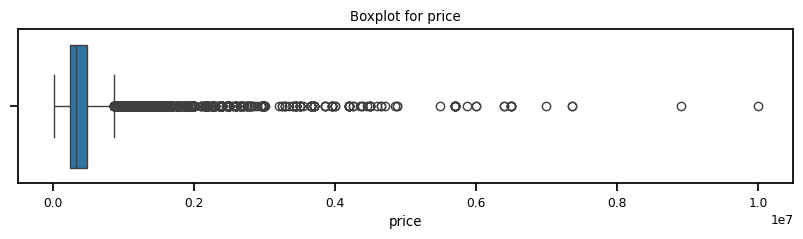

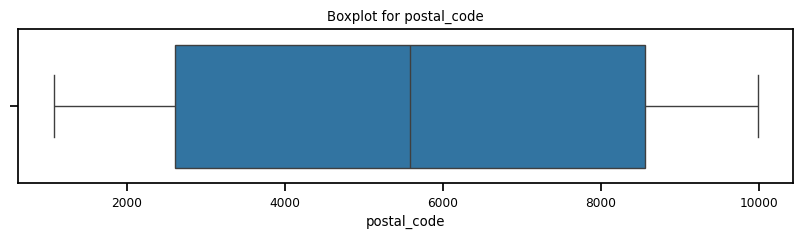

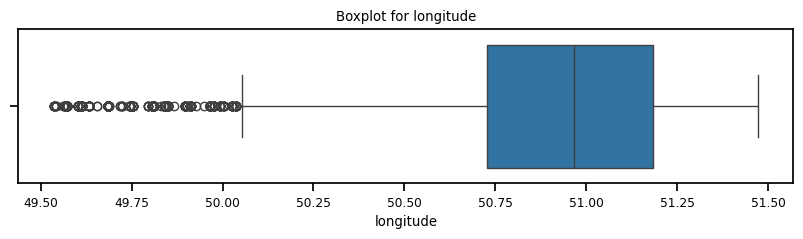

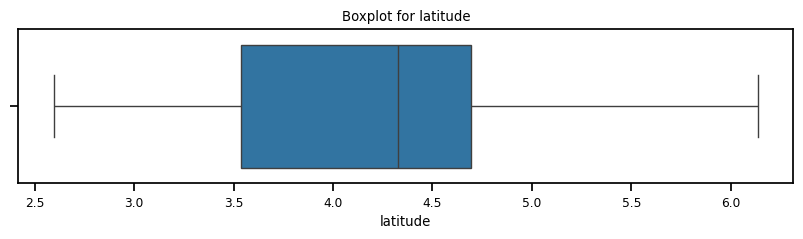

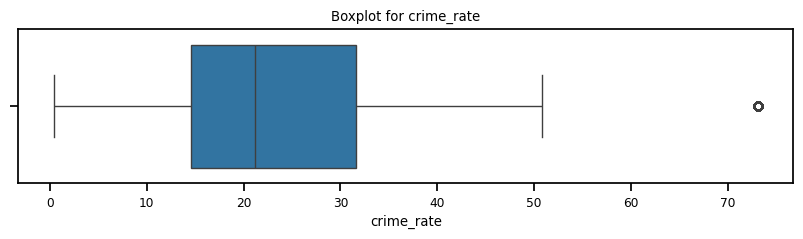

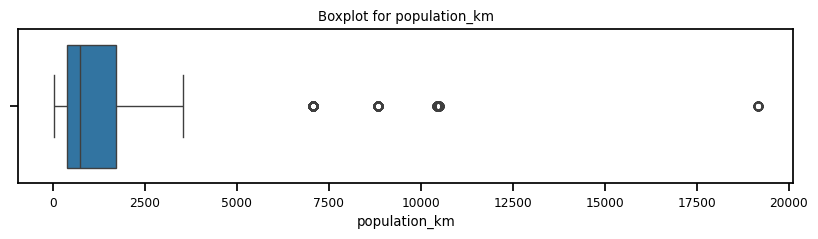

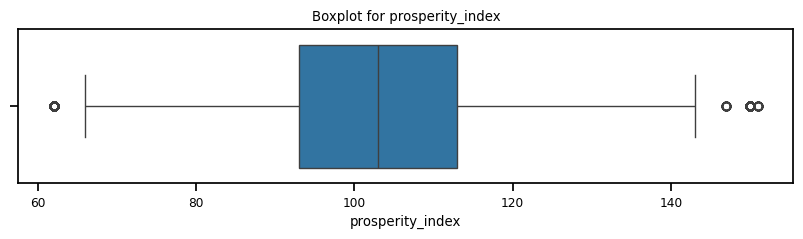

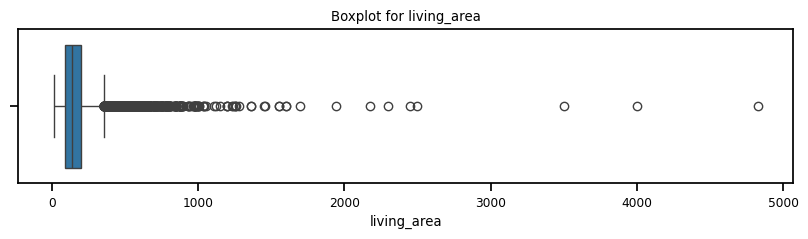

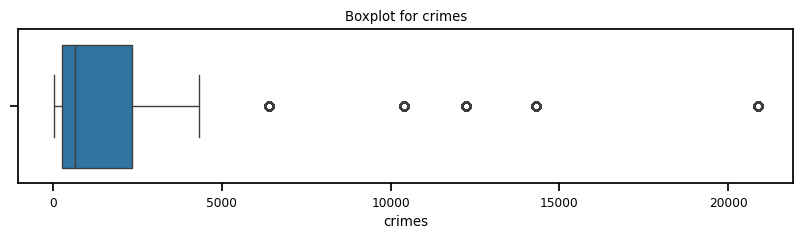

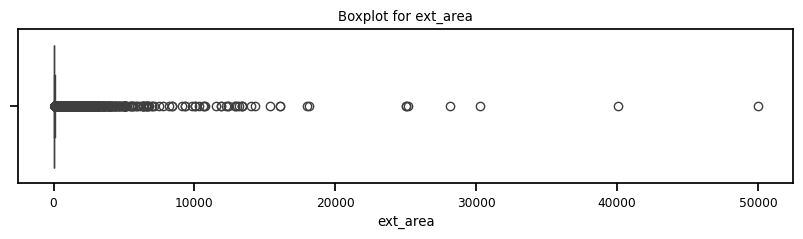

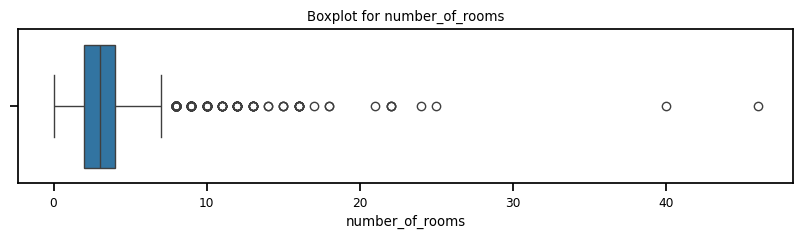

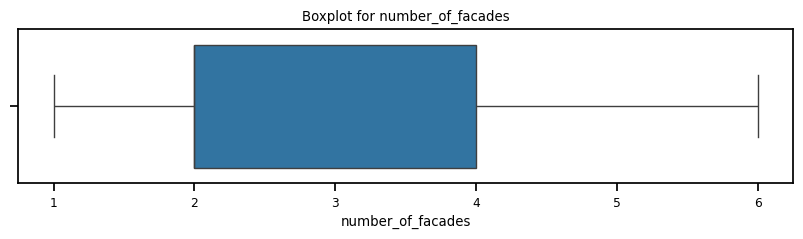

In [2014]:
# Plot outlier in continuous and discrete columns   
columns_to_plot = continuous_columns + discrete_columns
for column in columns_to_plot:
   plt.figure(figsize=(10, 2))
   sns.boxplot(x=real_estate_data[column])
   plt.title(f'Boxplot for {column}')
   plt.show()

In [2015]:
inliers_price, outliers_price = outliers('price')

Outliers: price
1870000    1
1875000    6
1890000    1
1895000    5
1900000    3
          ..
6500000    2
6995000    1
7365000    2
8900000    1
9999000    1
Name: count, Length: 111, dtype: int64.
Total sum of outliers: 343
Skew: 6.052024983060572 - Kurtosis: 59.46780747508759


In [2016]:
# Taking only inliers for 'price' column 
real_estate_data = real_estate_data.loc[real_estate_data['price'].isin(inliers_price)]

In [2017]:
real_estate_data['price'].describe()

count    1.908300e+04
mean     4.024249e+05
std      2.709268e+05
min      5.000000e+03
25%      2.350000e+05
50%      3.290000e+05
75%      4.700000e+05
max      1.850000e+06
Name: price, dtype: float64

In [2018]:
inliers_living, outliers_living = outliers('living_area')

Outliers: living_area
541.0      3
543.0      2
547.0      1
550.0     10
553.0      2
          ..
2450.0     1
2500.0     1
3502.0     1
4000.0     1
4829.0     1
Name: count, Length: 146, dtype: int64.
Total sum of outliers: 265
Skew: 8.557000065413629 - Kurtosis: 202.8931956086452


In [2019]:
# Taking only inliers for "Living_Area" column
real_estate_data = real_estate_data.loc[real_estate_data['living_area'].isin(inliers_living) | real_estate_data['living_area'].isna()]

In [2020]:
inliers_room, outliers_room = outliers('number_of_rooms')

Outliers: number_of_rooms
7     105
8      61
9      20
10     18
11      8
12      6
13      3
14      1
15      2
16      1
18      1
22      1
Name: count, dtype: int64.
Total sum of outliers: 227
Skew: 1.3732199358287098 - Kurtosis: 7.819197741358555


In [2021]:
# Taking only inliers for 'Number_of_Rooms' column 
real_estate_data = real_estate_data.loc[real_estate_data['number_of_rooms'].isin(inliers_room)]

In [2022]:
inliers_Facades, outliers_Facades = outliers('number_of_facades')

Outliers: number_of_facades
6.0    2
Name: count, dtype: int64.
Total sum of outliers: 2
Skew: 0.6429840503966392 - Kurtosis: -1.2036538080360417


In [2023]:
# Taking only inliers for 'Number_of_Facades' column 
real_estate_data = real_estate_data.loc[real_estate_data['number_of_facades'].isin(inliers_Facades) | real_estate_data['number_of_facades'].isna()]

For finding and deleting outliers in 'ext_space', zero values will not be taken into account, as zero represents observations where the feature Garden or Terrace does not exist.

In [2024]:
# Filter condition to exclude zeros
filter_outlier_ext = real_estate_data['ext_area'] > 0

# Pass column with filter condition
inliers_ext, outliers_ext = outliers('ext_area', filter_outlier_ext)

Outliers: ext_area
3083.0     1
3130.0     1
3175.0     2
3180.0     1
3200.0     1
          ..
14324.0    1
15382.0    1
16091.0    2
25000.0    2
30234.0    1
Name: count, Length: 81, dtype: int64.
Total sum of outliers: 101
Skew: 13.712710930034676 - Kurtosis: 295.70307751739426


In [2025]:
# Taking only inliers for 'Garden_Area' column
real_estate_data = real_estate_data[
    ~real_estate_data['ext_area'].isin(outliers_ext)
]

In [2026]:
real_estate_data.shape

(18488, 25)

### Exploratory data analysis (EDA)

* Discrete columns

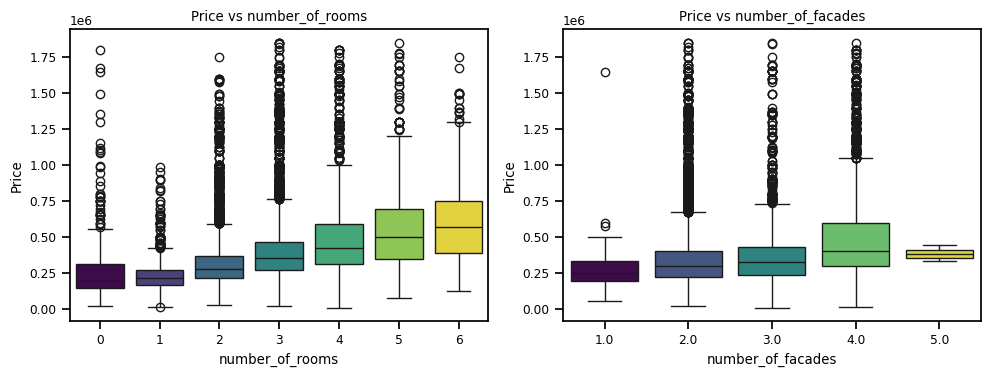

In [2027]:
# Plot discrete_columns
fig, axes = plt.subplots(1, len(discrete_columns), figsize=(10, 4))

for i, col in enumerate(discrete_columns):
    sns.boxplot(data=real_estate_data, x=col, y='price', hue=col, palette='viridis', legend=False, ax=axes[i])
    axes[i].set_title(f'Price vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Price')

plt.subplots_adjust(wspace=3)

plt.tight_layout()
plt.show()

In [2028]:
real_estate_data[real_estate_data['number_of_facades'] == 5].shape[0]

4

In [2029]:
real_estate_data = real_estate_data[real_estate_data['number_of_facades'] != 5]
real_estate_data[real_estate_data['number_of_rooms'] == 0]['type_of_property'].value_counts()

type_of_property
apartment    262
house        120
Name: count, dtype: int64

Usually only studios are know for having no separete room. All houses with 0 rooms will be change for the mode in the specific municipality

In [2030]:
# Group by 'type_of_property' and 'municipality' and calculate the mode of 'number_of_rooms'
mode_values = real_estate_data.groupby(['type_of_property', 'municipality'])['number_of_rooms'].agg(lambda x: x.mode()[0])

# Function to replace 0s with the mode based on group, for houses only
def replace_with_mode(row):
    if row['number_of_rooms'] == 0 and row['type_of_property'] == 'house':
        return mode_values.loc[(row['type_of_property'], row['municipality'])]
    return row['number_of_rooms']

# Apply the function to the 'number_of_rooms' column
real_estate_data['number_of_rooms'] = real_estate_data.apply(replace_with_mode, axis=1)

In [2031]:
# Group by 'type_of_property' and calculate the mean for 'number_of_rooms' and 'number_of_facades'
rooms_per_property_type = real_estate_data.groupby('type_of_property')['number_of_rooms'].mean()
facades_per_property_type = real_estate_data.groupby('type_of_property')['number_of_facades'].mean()

print("Average number of rooms per type of property:")
print(rooms_per_property_type)
print("Average number of facades per type of property:")
print(facades_per_property_type)

Average number of rooms per type of property:
type_of_property
apartment    1.988886
house        3.371325
Name: number_of_rooms, dtype: float64
Average number of facades per type of property:
type_of_property
apartment    2.251249
house        2.985872
Name: number_of_facades, dtype: float64


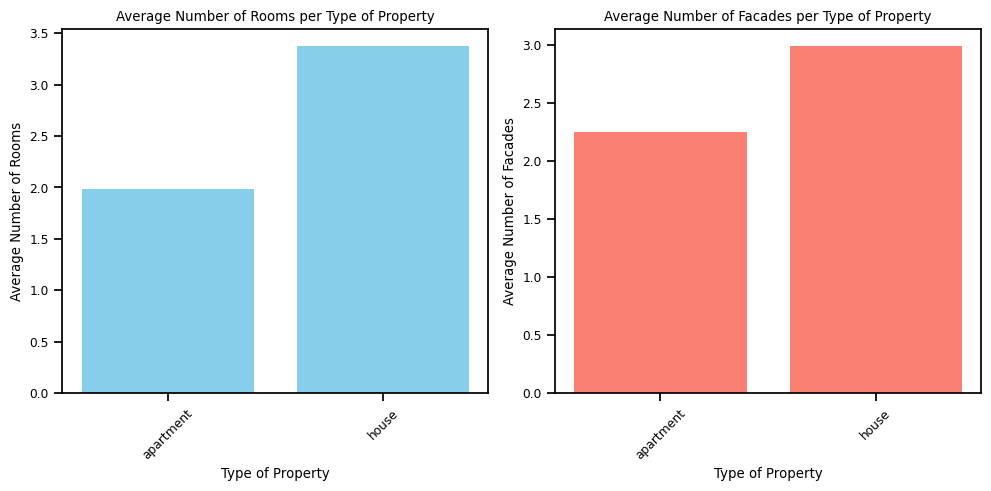

In [2032]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plotting the average number of rooms per type of property on the first subplot
axes[0].bar(rooms_per_property_type.index, rooms_per_property_type, color='skyblue')
axes[0].set_title('Average Number of Rooms per Type of Property')
axes[0].set_xlabel('Type of Property')
axes[0].set_ylabel('Average Number of Rooms')
axes[0].tick_params(axis='x', rotation=45)

# Plotting the average number of facades per type of property on the second subplot
axes[1].bar(facades_per_property_type.index, facades_per_property_type, color='salmon')
axes[1].set_title('Average Number of Facades per Type of Property')
axes[1].set_xlabel('Type of Property')
axes[1].set_ylabel('Average Number of Facades')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()

The number of rooms and number of facades provide information about the type of property. The column 'type_of_property' is redundant and will be deleted.

* Binary columns

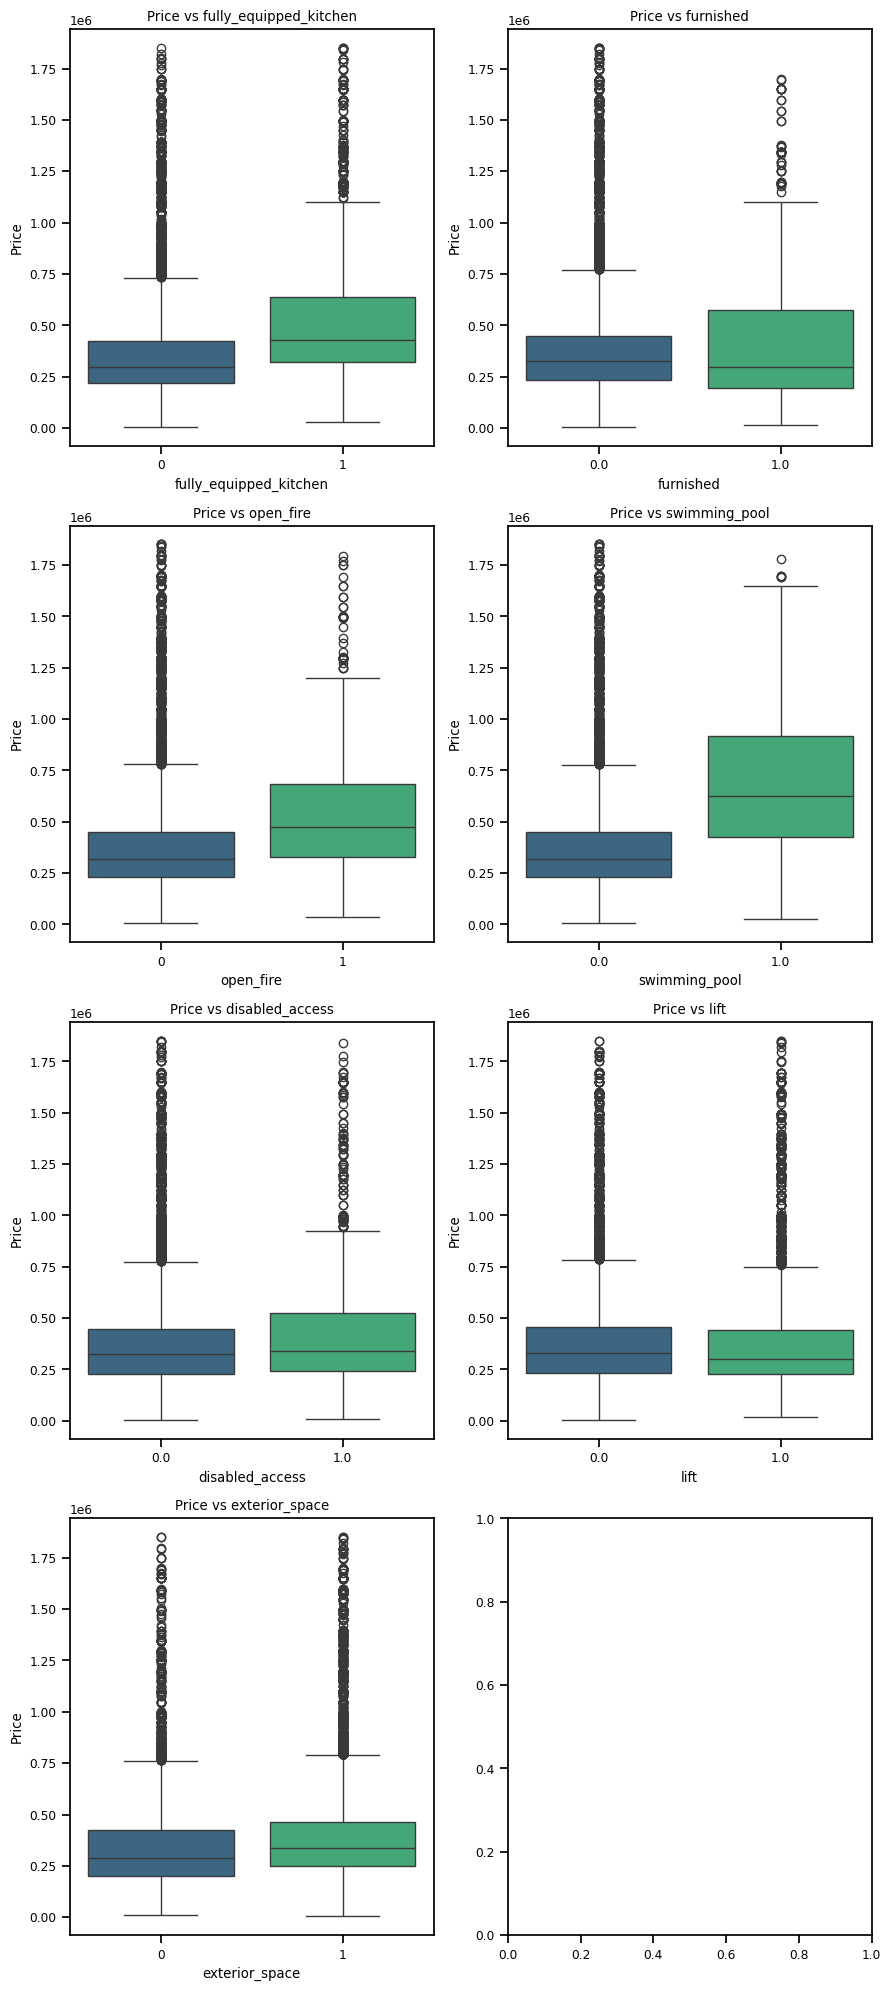

In [2033]:
# Plot Binary columns
n_columns = len(binary_columns)
n_rows = (n_columns + 1) // 2  

fig, axes = plt.subplots(n_rows, 2, figsize=(9, n_rows * 5))

axes = axes.flatten()

for i, col in enumerate(binary_columns):
    sns.boxplot(data=real_estate_data, x=col, y='price', hue=col, palette='viridis', legend=False, ax=axes[i])
    axes[i].set_title(f'Price vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Price')

plt.subplots_adjust(wspace=0.4, hspace=0.5)  
plt.tight_layout()  
plt.show()

The columns'disable_access' and 'lift' show the difference in price between properties that have the feature and those that do not.


In [2034]:
real_estate_data = real_estate_data.drop(columns=['disabled_access','lift'])

* Categorical columns

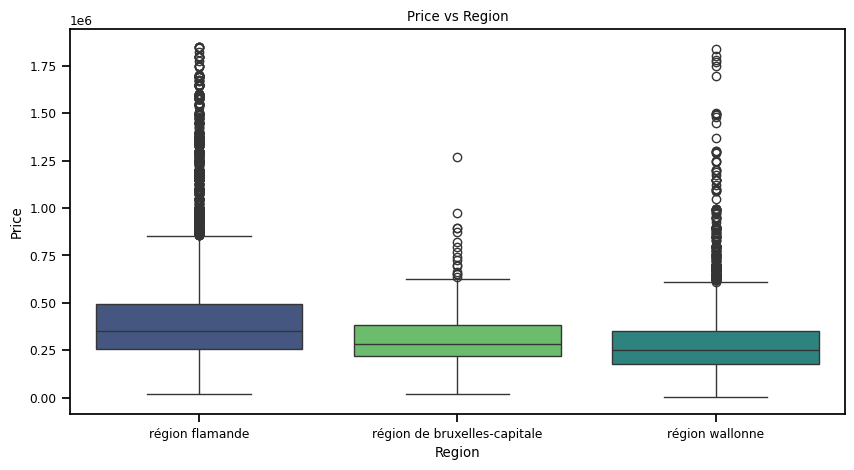

In [2035]:
# Plot region sorted using median
median_prices_region = real_estate_data.groupby('region')['price'].median().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.boxplot(data=real_estate_data, x='region', y='price', hue='region', palette='viridis', 
            legend=False, order=median_prices_region.index)

plt.title('Price vs Region')
plt.xlabel('Region')
plt.ylabel('Price')
plt.show()

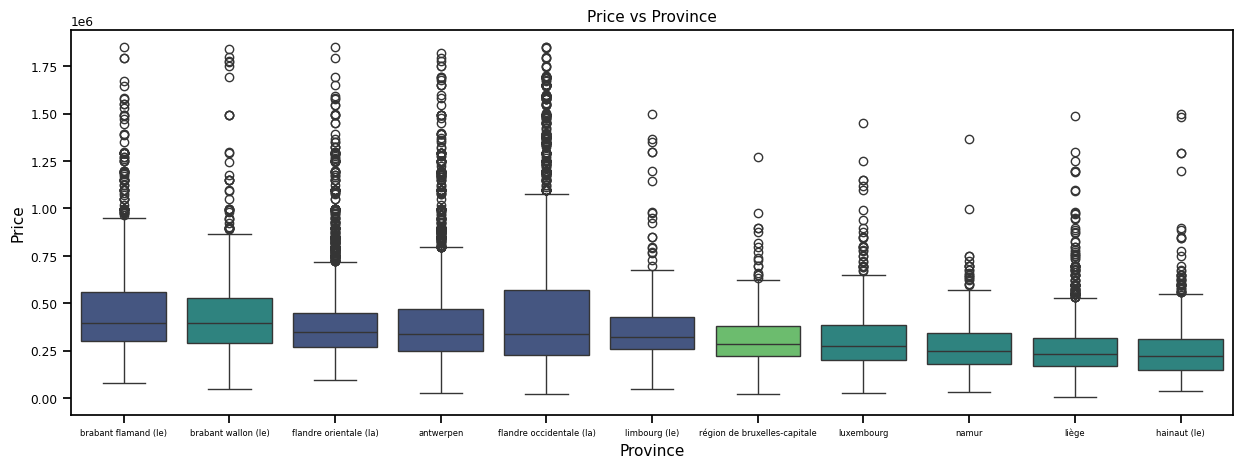

In [2036]:
# Plot province sorted using median
median_prices_province = real_estate_data.groupby('province')['price'].median().sort_values(ascending=False)

# Create the boxplot, ordering the provinces from higher to lower median price
plt.figure(figsize=(15, 5))
sns.boxplot(data=real_estate_data, x='province', y='price', hue='region', palette='viridis', 
            legend=False, order=median_prices_province.index)

plt.title('Price vs Province', fontsize=11)  
plt.xlabel('Province', fontsize=11)  
plt.ylabel('Price', fontsize=11)  
plt.xticks(fontsize=6)
plt.show()

Having both the 'region' and 'province' columns is redundant. Only one of these columns needs to be selected for the model, or the model needs to be tested with both to see which gives the best performance.

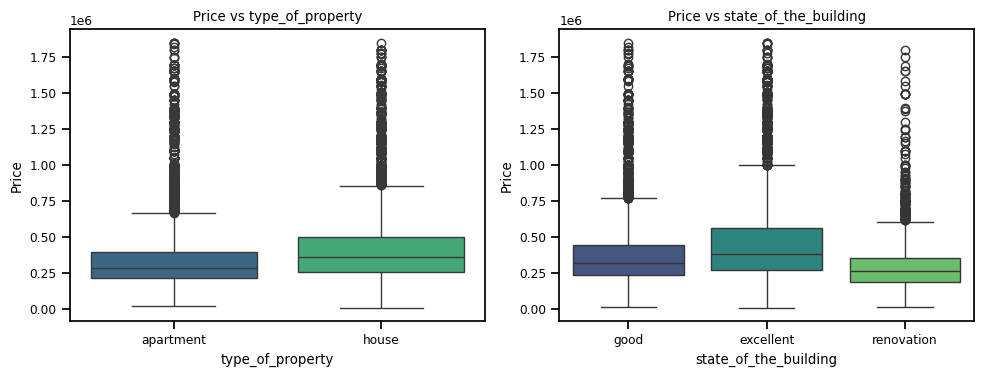

In [2037]:
cat_columns = ['type_of_property', 'state_of_the_building']

# Plot discrete_columns
fig, axes = plt.subplots(1, len(cat_columns), figsize=(10, 4))

for i, col in enumerate(cat_columns):
    sns.boxplot(data=real_estate_data, x=col, y='price', hue=col, palette='viridis', legend=False, ax=axes[i])
    axes[i].set_title(f'Price vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Price')

plt.subplots_adjust(wspace=3)

plt.tight_layout()
plt.show()

The columns 'municipality' and 'subtype_of_property' are no longer needed, as they were used to create new features and group other features in previous steps. The reasoning behind deleting these features is explained in the previous step.

In [2038]:
#real_estate_data = real_estate_data.drop(columns=['municipality', 'subtype_of_property'])

* Continuous columns

<Figure size 600x400 with 0 Axes>

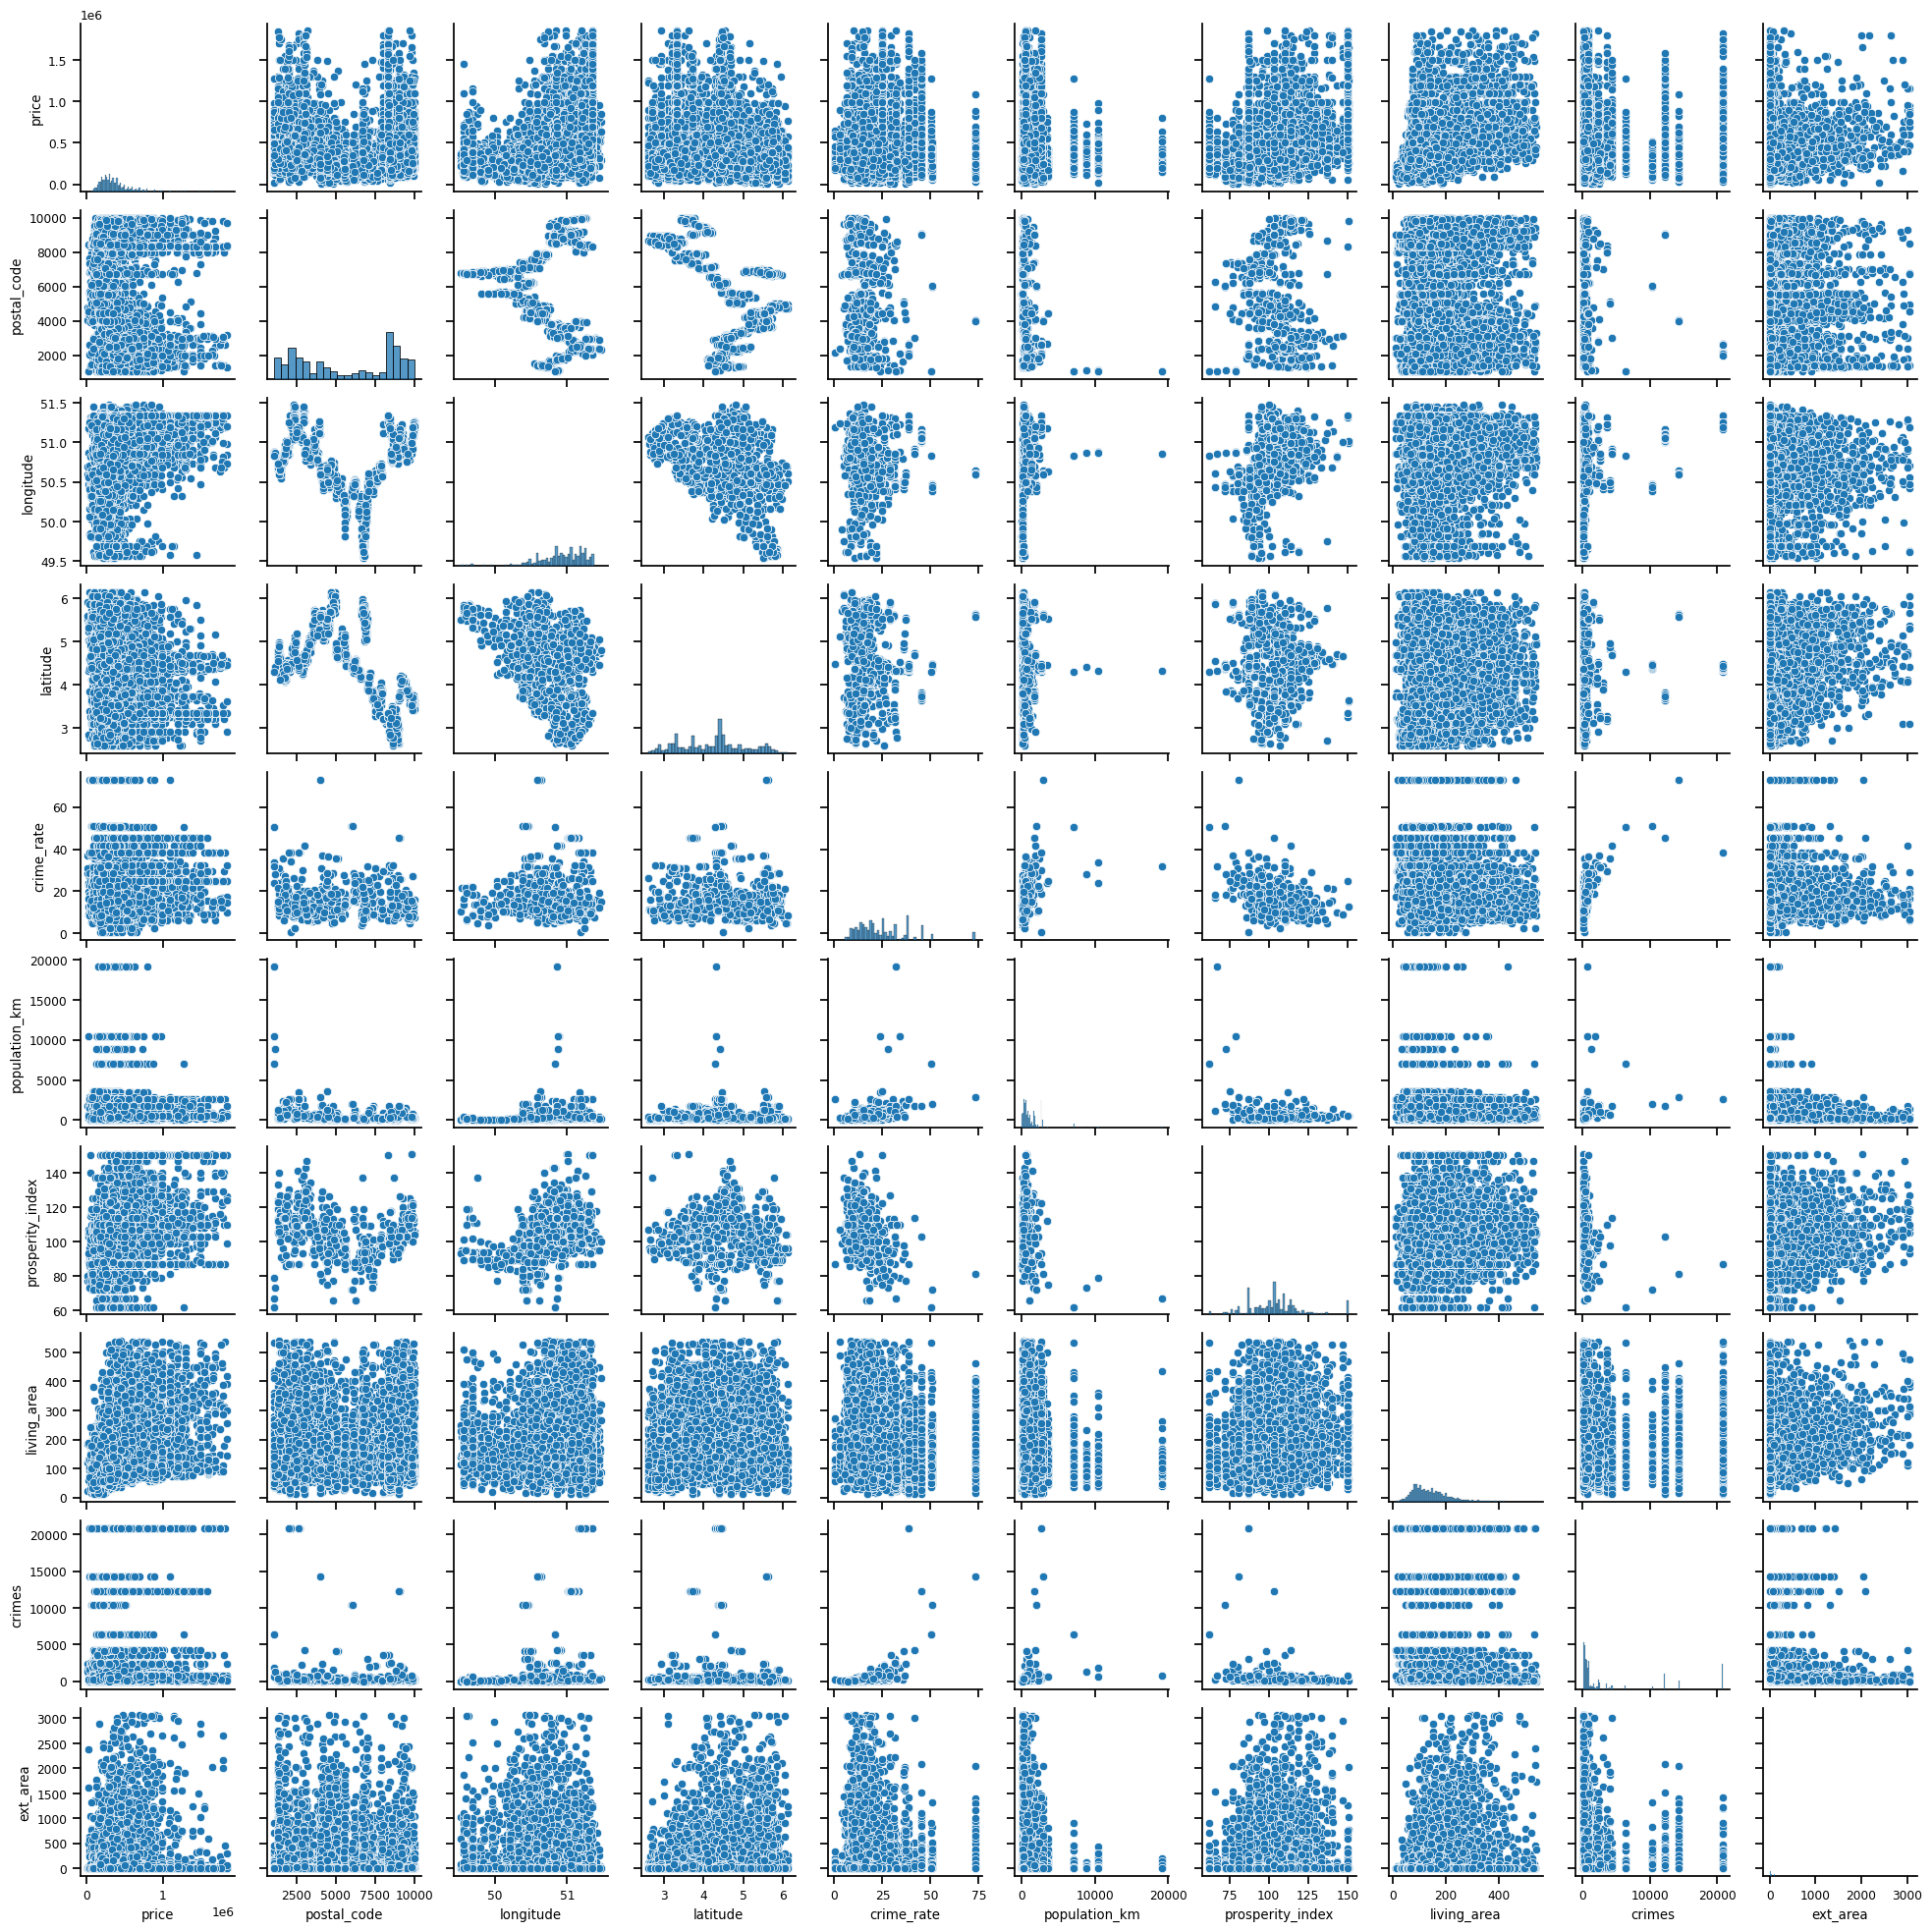

In [2039]:
# Plot pairwise relationships for numerical columns
plt.figure(figsize=(6, 4))
sns.set_context('notebook', font_scale=0.8)
sns.pairplot(real_estate_data[continuous_columns], height=2)
plt.show()

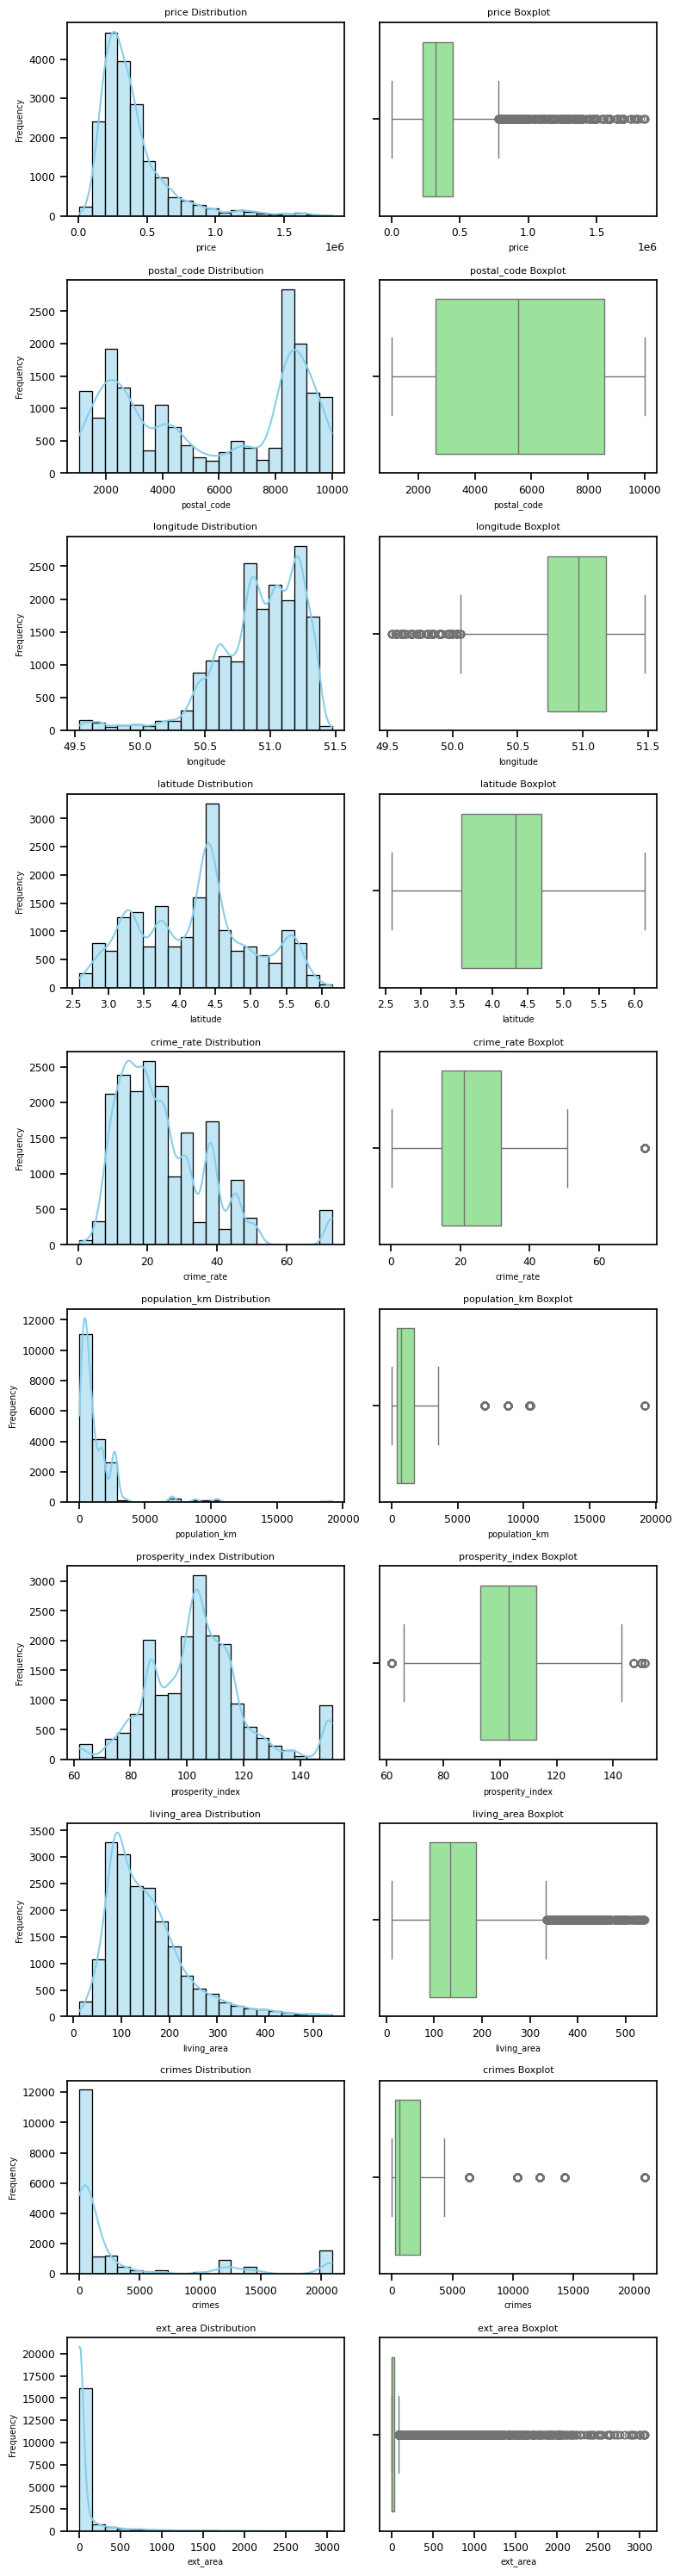

In [2040]:
# Plot - histogram and boxplot - for continuous columns
fig, axes = plt.subplots(len(continuous_columns), 2, figsize=(8, len(continuous_columns) * 3))

for i, column in enumerate(continuous_columns):
    # Histogram with KDE
    sns.histplot(real_estate_data[column], kde=True, ax=axes[i, 0], color='skyblue', bins=20)
    axes[i, 0].set_title(f'{column} Distribution', fontsize=8)
    axes[i, 0].set_xlabel(column, fontsize=7)
    axes[i, 0].set_ylabel('Frequency', fontsize=7)

    # Boxplot
    sns.boxplot(data=real_estate_data, x=column, ax=axes[i, 1], color='lightgreen')
    axes[i, 1].set_title(f'{column} Boxplot', fontsize=8)
    axes[i, 1].set_xlabel(column, fontsize=7)

plt.tight_layout()
plt.show()

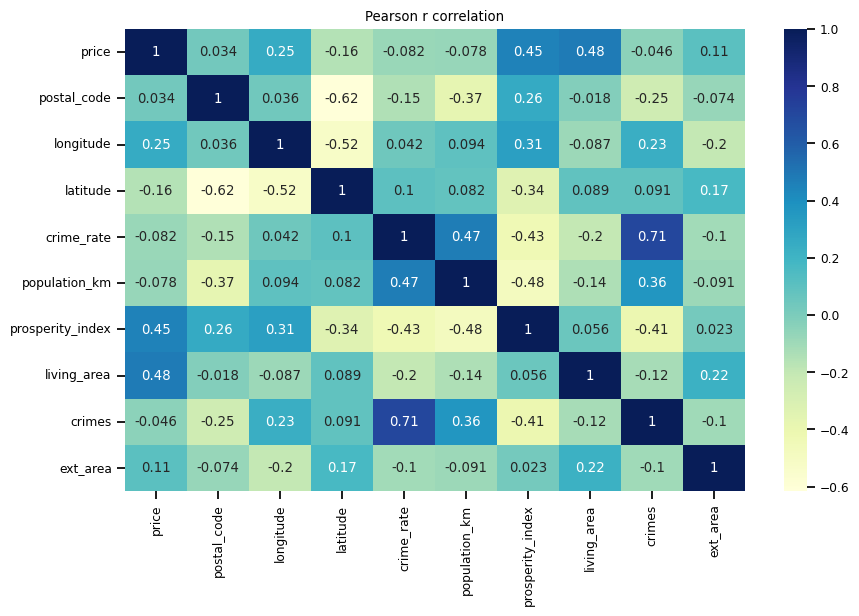

In [2041]:
plt.figure(figsize=(10,6))
sns.heatmap(real_estate_data[continuous_columns].corr(),annot=True, cmap= "YlGnBu")
plt.title("Pearson r correlation")
plt.show()

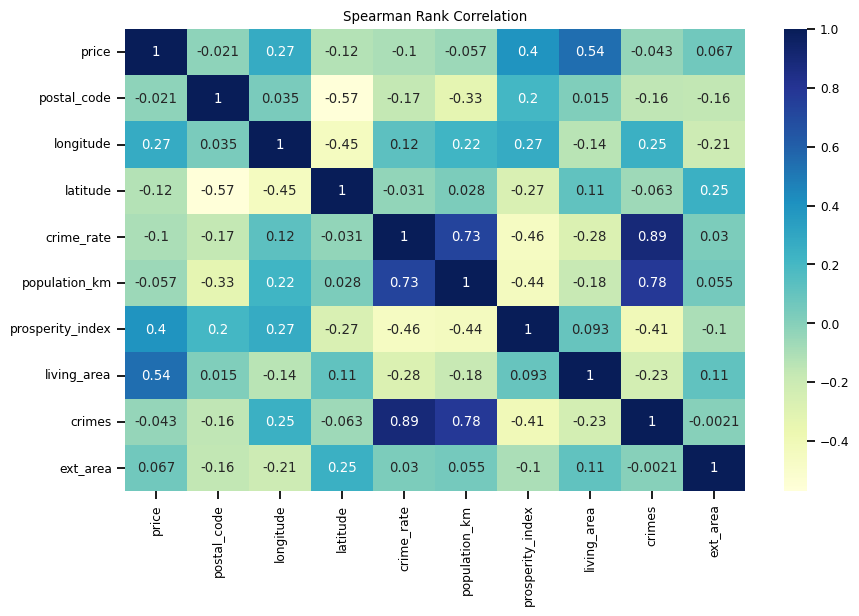

In [2042]:
plt.figure(figsize=(10,6))
sns.heatmap(real_estate_data[continuous_columns].corr(method='spearman'), annot=True, cmap="YlGnBu")
plt.title("Spearman Rank Correlation")
plt.show()

In [2043]:
# Calculate the correlation matrix for continuous columns
correlation_matrix = real_estate_data[continuous_columns].corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Feature"] = real_estate_data[continuous_columns].columns
vif["VIF"] = [variance_inflation_factor(real_estate_data[continuous_columns].values, i) for i in range(real_estate_data[continuous_columns].shape[1])]

# Display VIF
print("\nVariance Inflation Factor (VIF):")
print(vif)

Correlation Matrix:
                     price  postal_code  longitude  latitude  crime_rate  \
price             1.000000     0.033991   0.254446 -0.158803   -0.081979   
postal_code       0.033991     1.000000   0.035505 -0.615445   -0.145205   
longitude         0.254446     0.035505   1.000000 -0.522319    0.042073   
latitude         -0.158803    -0.615445  -0.522319  1.000000    0.101764   
crime_rate       -0.081979    -0.145205   0.042073  0.101764    1.000000   
population_km    -0.077745    -0.372551   0.094044  0.081704    0.472612   
prosperity_index  0.454284     0.256119   0.312210 -0.337341   -0.430912   
living_area       0.481603    -0.017919  -0.087410  0.088782   -0.200713   
crimes           -0.046101    -0.250957   0.230283  0.090701    0.708790   
ext_area          0.105406    -0.073760  -0.200856  0.172821   -0.104629   

                  population_km  prosperity_index  living_area    crimes  \
price                 -0.077745          0.454284     0.481603 -0.0

Prosperity Index (VIF = 7.77) and Living Area (VIF = 6.28) are the more related with price. 

Crime rate and population_km have weak correlations with price, these may not have strong predictive power. 

In [2044]:
#del real_estate_data['crime_rate']
#del real_estate_data['population_km']

'exterior_space' and 'ext_area' duplicate information. 

In [2045]:
del real_estate_data['exterior_space']

In decision trees, multicollinearity is handled implicitly through the feature selection process.

In [2046]:
real_estate_data = real_estate_data.drop_duplicates()
real_estate_data.shape

(18374, 22)

In [2047]:
real_estate_data.head(10)

,price,postal_code,longitude,latitude,region,province,municipality,crime_rate,population_km,prosperity_index,...,state_of_the_building,number_of_rooms,living_area,fully_equipped_kitchen,furnished,open_fire,number_of_facades,swimming_pool,crimes,ext_area
0,475000,1800,50.930129,4.428578,région flamande,brabant flamand (le),vilvoorde,22.742122,2199.232426,92.0,...,good,3,400.0,0,0.0,0,2.0,0.0,1079.0,0.0
1,895000,2000,51.248448,4.376134,région flamande,antwerpen,antwerpen,38.339890,2666.254939,87.0,...,good,3,286.0,1,0.0,0,2.0,0.0,20886.0,30.0
2,289000,8680,51.090212,2.972217,région flamande,flandre occidentale (la),koekelare,9.176391,223.812277,98.0,...,excellent,3,120.0,0,0.0,0,1.0,0.0,81.0,4.0
3,775000,2980,51.263556,4.682858,région flamande,antwerpen,zoersel,13.609966,583.095609,121.0,...,renovation,4,350.0,0,0.0,0,4.0,0.0,307.0,0.0
4,1495000,8670,51.121347,2.700627,région flamande,flandre occidentale (la),koksijde,21.628144,427.834883,137.0,...,renovation,4,148.0,0,1.0,0,2.0,0.0,466.0,0.0
5,259000,5030,50.562261,4.697015,région wallonne,namur,gembloux,17.285628,274.633658,110.0,...,good,3,154.0,0,0.0,0,4.0,0.0,458.0,200.0
7,1195000,8300,51.346652,3.331958,région flamande,flandre occidentale (la),knokke-heist,24.697054,527.878757,150.0,...,excellent,3,120.0,1,0.0,0,2.0,0.0,803.0,0.0
8,429210,9052,51.003447,3.708325,région flamande,flandre orientale (la),gent,45.408517,1708.806368,103.0,...,good,2,100.0,1,0.0,0,3.0,0.0,12242.0,12.0
9,314000,1770,50.866522,4.093036,région flamande,brabant flamand (le),liedekerke,23.406837,1377.249099,103.0,...,good,2,96.0,1,0.0,0,4.0,0.0,328.0,10.0
10,229000,2500,51.131602,4.561792,région flamande,antwerpen,lier,22.638053,766.455003,109.0,...,good,2,105.0,0,0.0,0,2.0,0.0,865.0,0.0


***

### Save dataframe

In [2048]:
real_estate_data.to_csv('data/real_estate_belguim.csv', index=False)